In [1]:
import sys
import time
import random
import datetime
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
from IPython.display import clear_output
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, UpSampling2D, Lambda, Conv2DTranspose
from tensorflow.keras import mixed_precision

from utils.plot_utils import plot_iou_trainId, plot_iou_catId
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
# from models.hrnet_gn_accumilate import HRNet_GN
# from models.seg.hrnet_accumilate import HRNet
from models.seg.hrnet import HRNet
from data_loaders import CityscapesLoader

K.clear_session()
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 



In [2]:
fine = True

n_classes = 20
img_height = 512
img_width = 1024

BATCH_SIZE = 6
BUFFER_SIZE = 512

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

In [3]:
pipeline = CityscapesLoader(
    img_height=img_height, 
    img_width=img_width, 
    n_classes=n_classes
)

In [4]:
dataset, info = tfds.load(
    name = 'cityscapes/semantic_segmentation', 
    data_dir = '/workspace/tensorflow_datasets/', 
    with_info = True,
    shuffle_files=True
)

In [5]:
train = dataset['train'].map(pipeline.load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
valid = dataset['validation'].map(pipeline.load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
eval = dataset['validation'].map(pipeline.load_image_eval, num_parallel_calls=tf.data.AUTOTUNE)

TRAIN_LENGTH = info.splits['train'].num_examples
VALID_LENGTH = info.splits['validation'].num_examples

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [6]:
print(train)
print(valid)

<ParallelMapDataset shapes: ((512, 1024, 3), (512, 1024)), types: (tf.float32, tf.int32)>
<ParallelMapDataset shapes: ((512, 1024, 3), (512, 1024)), types: (tf.float32, tf.int32)>


In [7]:
def label_to_rgb(mask):
    h = mask.shape[0]
    w = mask.shape[1]
    mask_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for val, key in trainid2label.items():
        indices = mask == val
        mask_rgb[indices.squeeze()] = key.color 
    return mask_rgb


def display(display_list, title=True):
    plt.figure(figsize=(15, 5), dpi=150) # dpi=200
    if title:
        title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        if title:
            plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

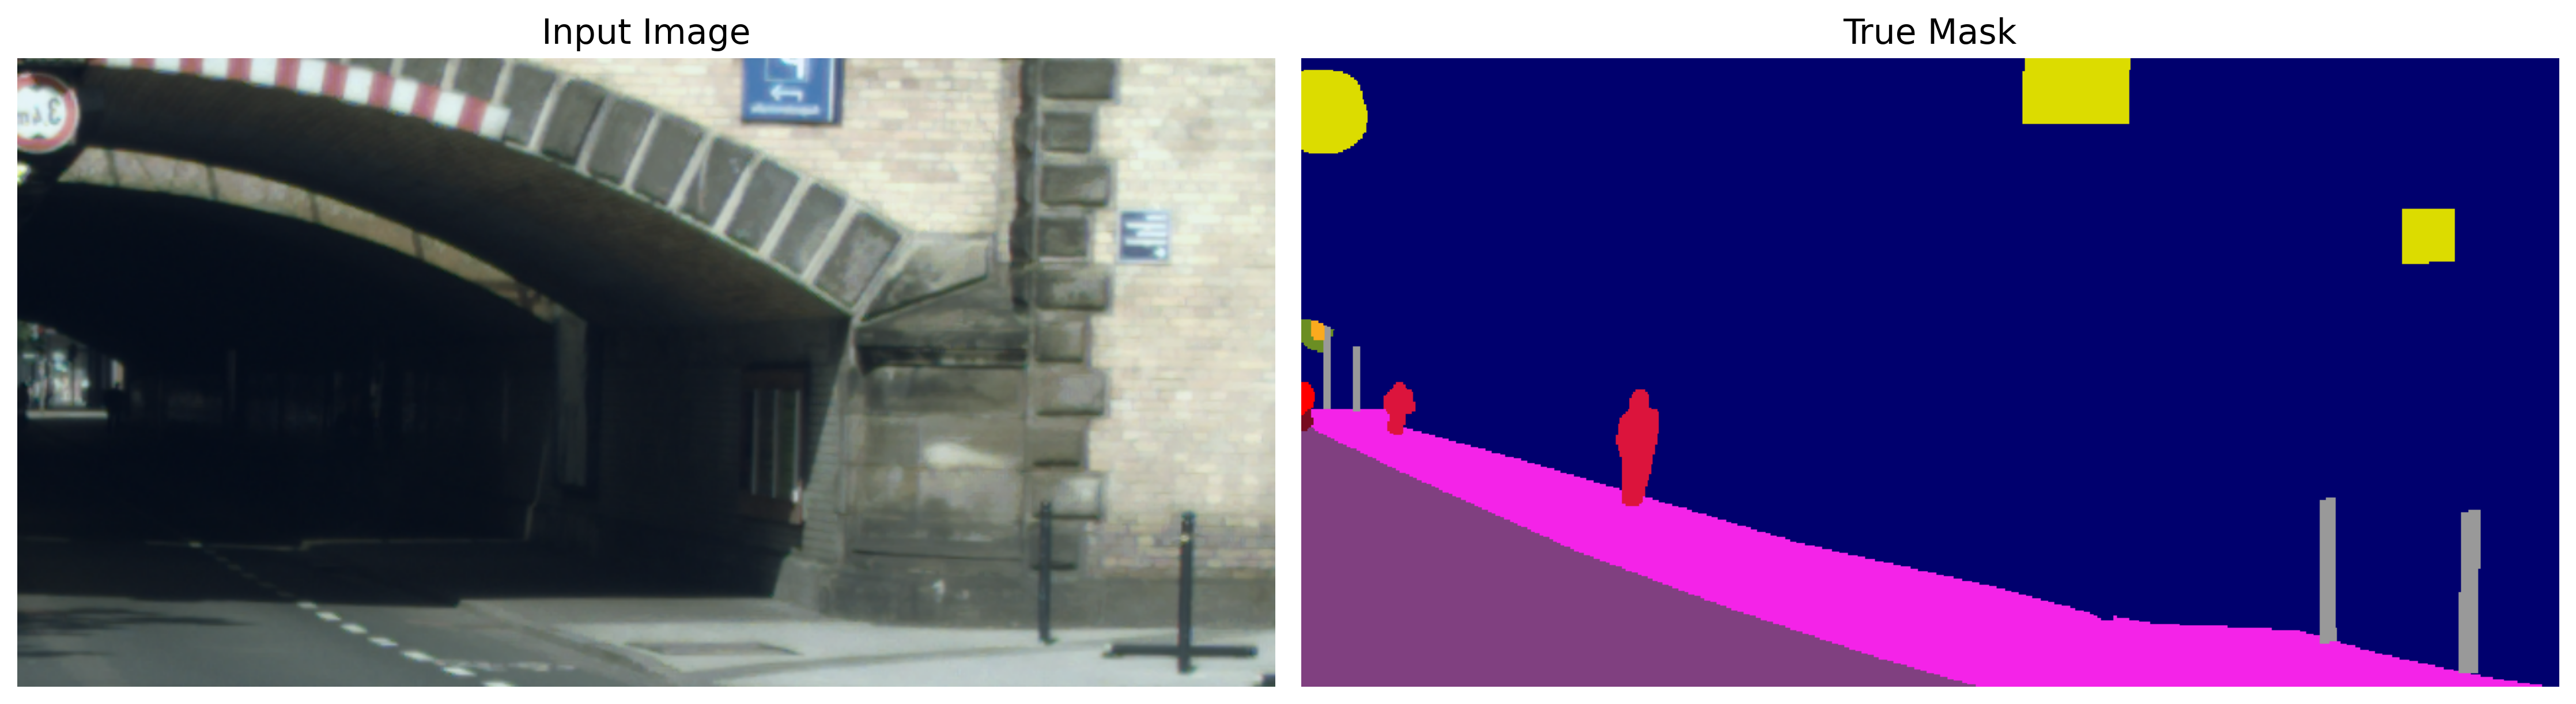

In [8]:
for image, mask in train.take(3): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

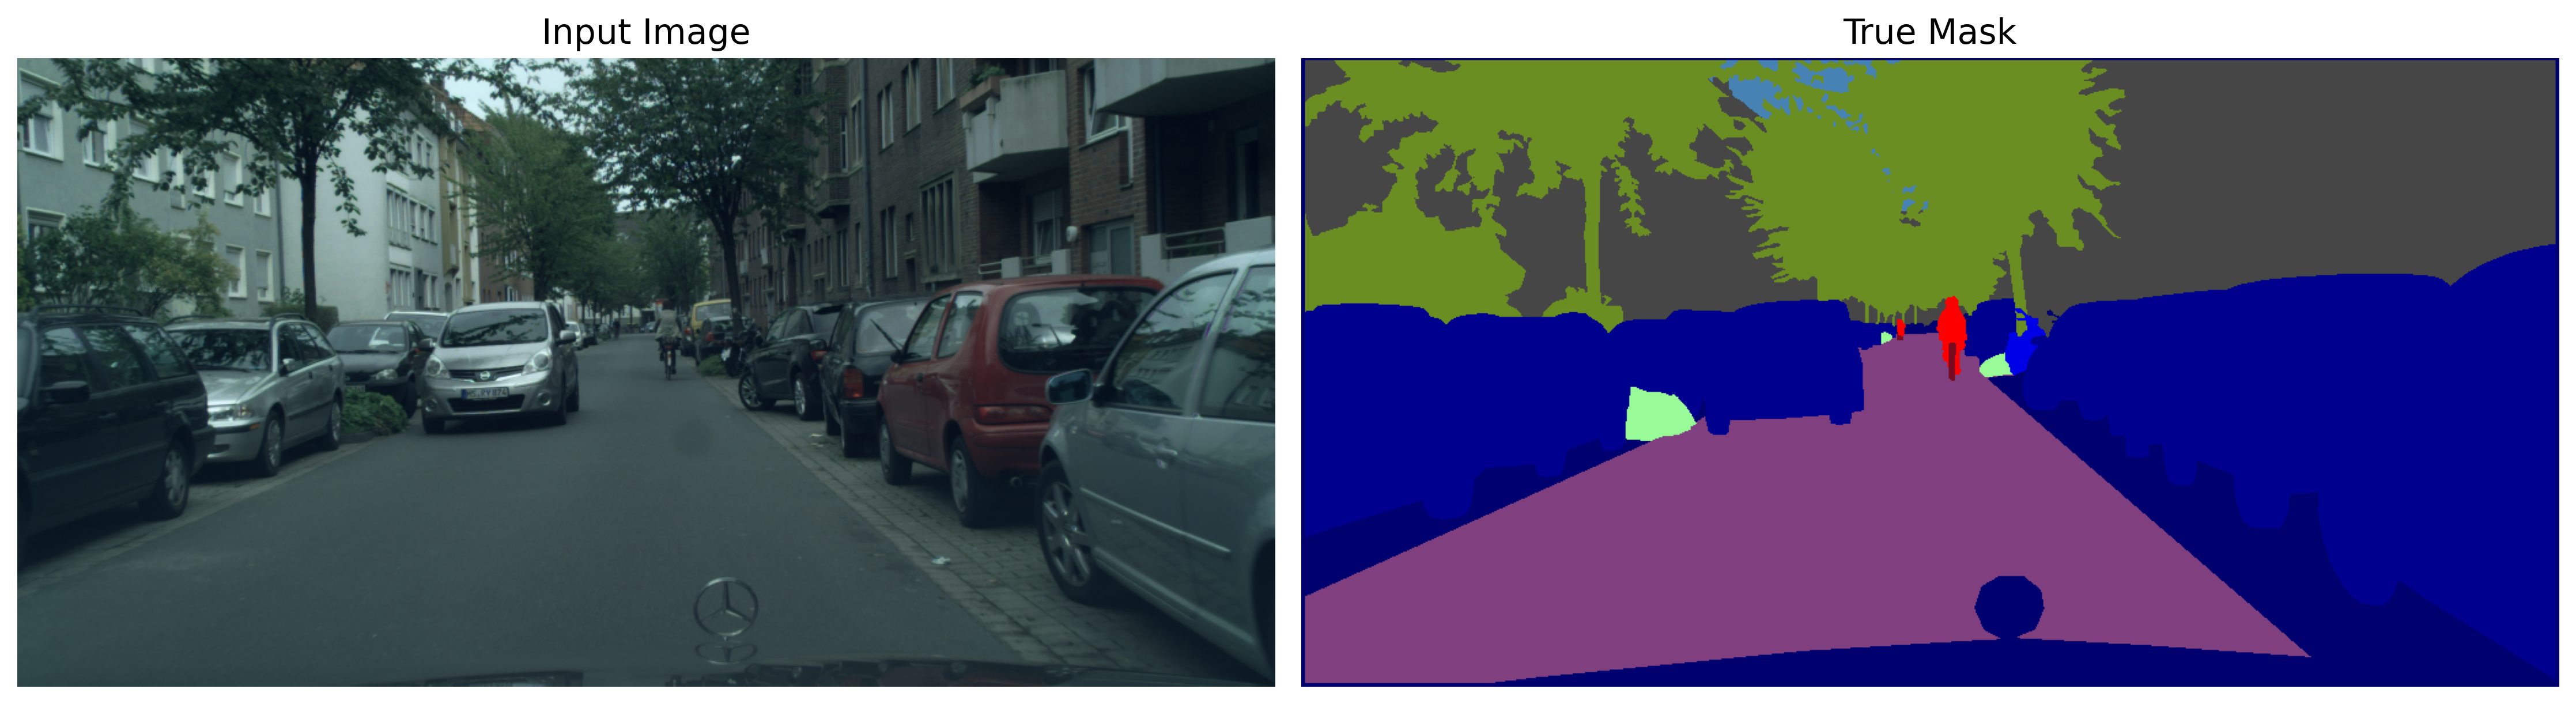

In [9]:
for image, mask in valid.take(3): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [10]:
model = HRNet(
    stage1_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 1,'BLOCK': 'BOTTLENECK','NUM_BLOCKS': [4]}, 
    stage2_cfg = {'NUM_MODULES': 1,'NUM_BRANCHES': 2,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4]},
    stage3_cfg = {'NUM_MODULES': 4,'NUM_BRANCHES': 3,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4]},
    stage4_cfg = {'NUM_MODULES': 3,'NUM_BRANCHES': 4,'BLOCK': 'BASIC',     'NUM_BLOCKS': [4, 4, 4, 4]},
    input_height = img_height, 
    input_width = img_width, 
    n_classes = n_classes, 
    W = 48,
    conv_upsample=False,
)

In [11]:
model.load_weights("weights/HRNet_CLF_W48.h5", by_name=True)

In [12]:
model.summary()

Model: "HRNet_W48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  36864     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (1, 128, 256, 192)        168192    
_________________________________________________________________
sequential_2 (Sequential)    (1, 128, 256, 48)         83

In [13]:
if fine:
    MODEL_PATH = "weights/"+model.name+".h5"
else:
    MODEL_PATH = "weights/"+model.name+"_coarse.h5"

# model.load_weights("weights/"+model.name+"_coarse.h5") 
# model.load_weights(MODEL_PATH)

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.squeeze(pred_mask)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = label_to_rgb(pred_mask.numpy())
    return pred_mask


def show_predictions():        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    display([sample_image, sample_mask, create_mask(pred_mask)])

        
def iou_coef(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred = tf.math.argmax(y_pred, axis=-1)
    y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)
    smooth = 1
    iou_total = 0
    for i in range(1, n_classes):
        intersection = tf.math.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i], axis=(1,2))
        union = tf.math.reduce_sum(y_true[:,:,:,i] + y_pred[:,:,:,i], axis=(1,2)) 
        iou = tf.math.reduce_mean(tf.math.divide_no_nan(2.*intersection+smooth, union+smooth), axis=0)
        iou_total += iou
    return iou_total/(n_classes-1)

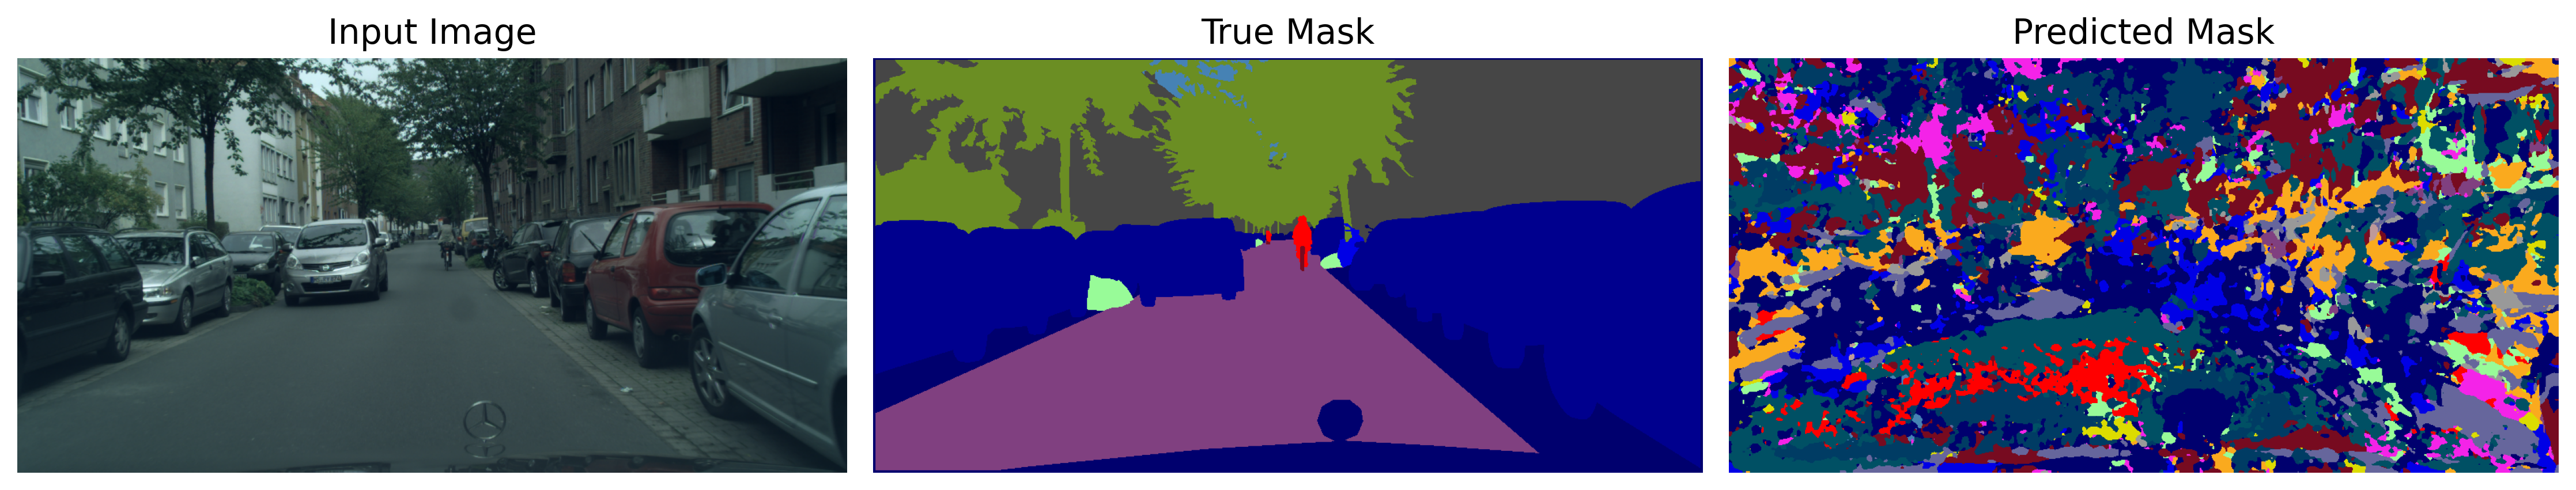

In [15]:
show_predictions()

In [16]:
# CURR_EPOCH = 59 + 57
EPOCHS = 150 # - CURR_EPOCH
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE 
VALIDATION_STEPS = VALID_LENGTH // BATCH_SIZE 
DECAY_STEPS = (STEPS_PER_EPOCH * EPOCHS) # // ACCUM_STEPS
print("Decay steps: {}".format(DECAY_STEPS))

Decay steps: 74250


In [17]:
# curr_lr = 1e-2 * ((1/2)**(CURR_EPOCH // 15))
# curr_lr

In [18]:
learning_rate_fn = PolynomialDecay(
    initial_learning_rate = 5e-3,
    decay_steps = DECAY_STEPS,
    end_learning_rate = 5e-6,
    power = 0.9
)

In [19]:
def weighted_cross_entropy_loss(y_true_labels, y_pred_logits):
    c_weights = [0.0,    2.602,  6.707,  3.522,  9.877, 9.685,  9.398,  10.288, 9.969,  4.336, 
                 9.454,  7.617,  9.405,  10.359, 6.373, 10.231, 10.262, 10.264, 10.394, 10.094] 
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_labels, logits=y_pred_logits)  
    weights = tf.gather(c_weights, y_true_labels)  
    losses = tf.multiply(losses, weights)
    return tf.math.reduce_mean(losses)

In [20]:
model.compile(
    optimizer = Adam(learning_rate=learning_rate_fn), #SGD(learning_rate=learning_rate_fn, momentum=0.9, decay=0.0005),
    loss = weighted_cross_entropy_loss,
    metrics = ['accuracy', iou_coef]
)

In [21]:
callbacks = [
    # EarlyStopping(monitor='val_iou_coef', mode='max', patience=40, verbose=2),
    # ReduceLROnPlateau(monitor='val_iou_coef', mode='max', patience=10, factor=0.5, min_lr=1e-5, verbose=2),
    ModelCheckpoint(MODEL_PATH, monitor='val_iou_coef', mode='max', 
                    verbose=2, save_best_only=True, save_weights_only=True)    
]

In [22]:
print(valid_dataset)

<BatchDataset shapes: ((None, 512, 1024, 3), (None, 512, 1024)), types: (tf.float32, tf.int32)>


In [ ]:
results = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/150
495/495 [==============================] - 322s 604ms/step - loss: 5.8844 - accuracy: 0.6351 - iou_coef: 0.5361 - val_loss: 4.0322 - val_accuracy: 0.6989 - val_iou_coef: 0.5085

Epoch 00001: val_iou_coef improved from -inf to 0.50847, saving model to weights/HRNet_W48.h5
Epoch 2/150
495/495 [==============================] - 300s 603ms/step - loss: 3.6778 - accuracy: 0.7417 - iou_coef: 0.5533 - val_loss: 4.1742 - val_accuracy: 0.6711 - val_iou_coef: 0.5369

Epoch 00002: val_iou_coef improved from 0.50847 to 0.53694, saving model to weights/HRNet_W48.h5
Epoch 3/150
495/495 [==============================] - 304s 612ms/step - loss: 3.1671 - accuracy: 0.7659 - iou_coef: 0.5666 - val_loss: 2.1587 - val_accuracy: 0.7526 - val_iou_coef: 0.5257

Epoch 00003: val_iou_coef did not improve from 0.53694
Epoch 4/150
495/495 [==============================] - 295s 596ms/step - loss: 2.6947 - accuracy: 0.7904 - iou_coef: 0.5774 - val_loss: 2.6476 - val_accuracy: 0.7498 - val_iou_coef: 0.

495/495 [==============================] - 302s 610ms/step - loss: 1.3648 - accuracy: 0.8585 - iou_coef: 0.6485 - val_loss: 1.1927 - val_accuracy: 0.8063 - val_iou_coef: 0.6401

Epoch 00033: val_iou_coef improved from 0.62453 to 0.64010, saving model to weights/HRNet_W48.h5
Epoch 34/150
495/495 [==============================] - 305s 617ms/step - loss: 1.3215 - accuracy: 0.8562 - iou_coef: 0.6612 - val_loss: 1.2061 - val_accuracy: 0.8049 - val_iou_coef: 0.5803

Epoch 00034: val_iou_coef did not improve from 0.64010
Epoch 35/150
495/495 [==============================] - 301s 609ms/step - loss: 1.2243 - accuracy: 0.8605 - iou_coef: 0.6671 - val_loss: 1.1038 - val_accuracy: 0.8122 - val_iou_coef: 0.6399

Epoch 00035: val_iou_coef did not improve from 0.64010
Epoch 36/150
495/495 [==============================] - 303s 613ms/step - loss: 1.2480 - accuracy: 0.8603 - iou_coef: 0.6706 - val_loss: 1.2660 - val_accuracy: 0.8058 - val_iou_coef: 0.6312

Epoch 00036: val_iou_coef did not improve 

In [ ]:
results = model.history

In [ ]:
def plot_history(results, model):
         
    plt.figure(figsize=(15,7))
    plt.subplot(1,3,1)  

    plt.plot(results.history['loss'], 'r', label='Training loss')
    plt.plot(results.history['val_loss'], 'b', label='Validation loss')
    plt.title("Loss: "+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,2)
    plt.plot(results.history['accuracy'], 'r', label='Training accuracy')
    plt.plot(results.history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title('Accuracy: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})

    plt.subplot(1,3,3)
    plt.plot(results.history['iou_coef'], 'r', label='IoU coefficient')
    plt.plot(results.history['val_iou_coef'], 'b', label='Validation IoU coefficient')
    plt.title('IoU Coefficient: '+model.name, fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(prop={'size': 14})
    
    if fine:
        plt.savefig("plots/"+model.name+"_learning_curves.png")
    else:
        plt.savefig("plots/"+model.name+"_learning_curves_coarse.png")
    plt.show()

In [ ]:
plot_history(results, model)

### Evaluation


In [ ]:
# K.clear_session()

In [ ]:
model.load_weights(MODEL_PATH)

In [ ]:
def evaluate_iou(model, dataset, n_samples):
    
    inf_times = np.zeros((n_samples, ))
    miou_op =  tf.keras.metrics.MeanIoU(num_classes=n_classes-1)
    
    for idx, (image, mask) in enumerate(dataset):
        print("\r Predicting {} \ {} ".format(idx+1, n_samples), end='')
        
        X = np.expand_dims(image.numpy(), axis=0)
        y_true = np.expand_dims(mask.numpy(), axis=0)
        
        t_start = time.time()
        y_pred = model.predict(X)
        t_end = time.time()
        t_inf = t_end-t_start
        
        inf_times[idx] = t_inf
        
        if "U2Net" in model.name:
            y_pred = y_pred[0]
            
        y_pred = tf.image.resize(y_pred, (1024, 2048))
        threshold = tf.math.reduce_max(y_pred, axis=-1, keepdims=True)
        y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        
        y_pred = tf.cast(tf.squeeze(y_pred, axis=0), tf.int32)
        y_true = tf.cast(tf.squeeze(y_true, axis=0), tf.int32)
        

        y_true = tf.one_hot(tf.cast(y_true, tf.int32), n_classes)
        y_true = tf.argmax(y_true[:,:,1:], axis=-1)
        y_pred = tf.argmax(y_pred[:,:,1:], axis=-1)
                
        miou_op.update_state(y_true, y_pred)
        
        if idx == (n_samples-1):
            break
    
    print("Average inference time: {:.2f}s".format(np.mean(inf_times)))
            
    return miou_op

In [ ]:
miou_op = evaluate_iou(model=model, dataset=eval, n_samples=VALID_LENGTH)
iou_mean = miou_op.result().numpy()

In [ ]:
union_int = np.sum(miou_op.get_weights()[0], axis=0) + np.sum(miou_op.get_weights()[0], axis=1)
inters = np.diag(miou_op.get_weights()[0])
ious = inters / (union_int-inters+1)

In [ ]:
plot_iou_trainId(
    trainId_label_map=trainid2label,
    catId_label_map=catid2label, 
    n_classes=n_classes, 
    iou_class=ious,
    model=model, 
    iou_mean=iou_mean,
)

In [ ]:
def visualize_confusion_matrix(confusion, metric, label_classes, model):
    plt.figure(figsize=(14,14))
    plt.title("{} Confusion Matrix, with Mean IoU = {:.3f}".format(model.name, metric), fontsize=22)
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-90, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.grid(False)
    fig.tight_layout()
    plt.show()

In [ ]:
visualize_confusion_matrix(
    confusion = miou_op.get_weights()[0] / np.sum(miou_op.get_weights()[0], axis=0), 
    metric = iou_mean, 
    label_classes = [trainid2label[i].name for i in range(1, n_classes)],
    model = model
)

In [ ]:
def show_predictions(sample_image, sample_mask):        
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    if "U2Net" in model.name:
        pred_mask = pred_mask[0]
    # sample_mask = tf.argmax(sample_mask, axis=-1)
    sample_mask = sample_mask[..., tf.newaxis]
    sample_mask = label_to_rgb(sample_mask.numpy())
    display([sample_image, sample_mask, create_mask(pred_mask)])

In [ ]:
for image, mask in valid.take(96): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in valid.take(4): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)

In [ ]:
for image, mask in valid.take(27): 
    sample_image, sample_mask = image, mask
show_predictions(sample_image, sample_mask)